In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


### Feature Engineering and selection
- here we start by exctracting the order day of the week and order month in as it's possible to contribute to order final status
- As a redundunt and safety step, we fill the null value of numerical columns with zeros and categorical columns with modes (the most frequent value)
- We then select the features that could have effect on the ordering process and completion
- Notice we didn't select features that could cause data leakage such as the date(we already have the day and month) and also the SKU, category and size which are already implied by the ASIN
- Then we split the data to train and test sets

In [2]:
df = pd.read_csv('clean_amazon_sales_report.csv')

# Feature engineering
df['order_date'] = pd.to_datetime(df['Date'])
df['order_month'] = df['order_date'].dt.month
df['order_day'] = df['order_date'].dt.dayofweek


# Fill missing values for numerical columns with median
for col in df.select_dtypes(include=[np.number]):
    df.fillna({col:df[col].median()}, inplace=True)

# Fill missing values for categorical columns with mode
for col in df.select_dtypes(include=[object]):
    df.fillna({col:df[col].mode()[0]}, inplace=True)

# Define features and target
features = df[['order_month','order_day','Fulfilment','Sales Channel ','ship-service-level','Amount','ship-postal-code','B2B','fulfilled-by','ASIN']] 
target = df['Status']

# Identify categorical and numerical features
categorical_features = features.select_dtypes(include=['object']).columns
numerical_features = features.select_dtypes(include=[np.number]).columns



C:\Users\PC\AppData\Local\Temp\ipykernel_17708\3869839566.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('clean_amazon_sales_report.csv')
C:\Users\PC\AppData\Local\Temp\ipykernel_17708\3869839566.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna({col:df[col].mode()[0]}, inplace=True)


In [3]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


### Training
Here we train a random forest classifier with 27 candidate hyperparameter setting to be done through grid search and 5-Fold cross validation

In [4]:
# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define hyperparameters for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [ 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}



# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['order_month', 'order_day', 'Amount', 'ship-postal-code'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['Fulfilment', 'Sales Channel ', 'ship-service-level', 'fulfilled-by',
       'ASIN'],
      dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, 30],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [8]:
# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))



Accuracy: 0.83
Classification Report:


c:\Users\PC\Desktop\slash_task\slash_task\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                               precision    recall  f1-score   support

                    Cancelled       0.00      0.00      0.00      3640
                      Pending       0.00      0.00      0.00       133
Pending - Waiting for Pick Up       0.00      0.00      0.00        58
                      Shipped       0.87      1.00      0.93     15537
            Shipped - Damaged       0.00      0.00      0.00         1
 Shipped - Delivered to Buyer       0.73      1.00      0.85      5793
   Shipped - Out for Delivery       0.00      0.00      0.00         5
          Shipped - Picked Up       0.00      0.00      0.00       182
  Shipped - Rejected by Buyer       0.00      0.00      0.00         2
 Shipped - Returned to Seller       0.00      0.00      0.00       414
Shipped - Returning to Seller       0.00      0.00      0.00        30

                     accuracy                           0.83     25795
                    macro avg       0.15      0.18      0.16     25795
    

c:\Users\PC\Desktop\slash_task\slash_task\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\Desktop\slash_task\slash_task\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


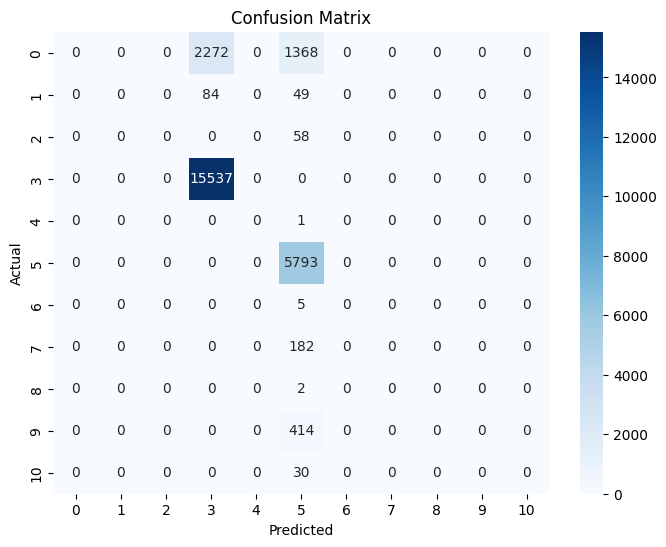

In [6]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

### Save
finally we save the model weights

In [9]:
import joblib

# Save the model
model_filename = 'random_forest_model.pkl'
joblib.dump(best_model, model_filename)
print(f"Model saved to {model_filename}")


Model saved to random_forest_model.pkl
